# Problem need to be addressed 

In this research, we proposal a new fault tolerance analysis technique - fault tolerance boundary is designed specific to the data variables.

why the huristic work, or why it does not work.


# Can you think a neural network method to understand program's property?
# Understand the propagation value of the nearest neighbor.
# Sampling method



1. What's the fault tolerance boundary.
2. It's a technique can be equivlent to the fault injection campaign.
3. We propose a method to approximate the boundary.
    1. heuristic method to measure the boundary.
    2. correlation analysis between variables to understand the relationship between the fault tolerance across variables.
4. label propagation and active learning.
5. The why masked prediction fail also can we use the SDC run to predict the program's outcome

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import random
import math
from IPython.core.debugger import set_trace
from datetime import datetime
import sys
import time
random.seed(datetime.now())

from utility import sampling

In [80]:
DATASET = "fft" #current available datasets fft, lu, cg, other potential dataset.,

In [81]:
# Threshold that used to decide whether the final outcome is SDC or Masked. For the loading data
# set, there are two different datasets. One is the exhaust fault injection campaign which contains
# all the fault injection information. The other is the test data set which is the sample experiment 
# contain the detail propagation information used for the downstream propagation analysis.
PROPAGATION_DATA_PATH = ""
CAMPAIGN_DATA_PATH = ""
PROPAGATION_INJECTION_DATA_PATH = ""
THRESHOLD = 0
BIT_SIZE = 0

if DATASET == "fft":
    PROPAGATION_DATA_PATH = "../static/data/fft/fft_complete"
    CAMPAIGN_DATA_PATH = "../static/data/fft/fft_injectlog.log"
    THRESHOLD = 0.001
    BIT_SIZE = 64
elif DATASET == "cg":
    PROPAGATION_DATA_PATH = "../static/data/cg/cg_in8"
    CAMPAIGN_DATA_PATH = "../static/data/cg/cg_in8/injectlog.log"
    THRESHOLD = 0.07
    BIT_SIZE = 64
elif DATASET == "lu":
    PROPAGATION_DATA_PATH = "../static/data/lu/lu20000"
    CAMPAIGN_DATA_PATH = "../static/data/lu/injectlog.log"
    THRESHOLD = 0.0001
    BIT_SIZE = 64
elif DATASET == "bs":
    PROPAGATION_DATA_PATH = "../static/data/bs/bs"
    CAMPAIGN_DATA_PATH = "../static/data/bs/injectlog_complete.log"
    THRESHOLD = 0.0001
    BIT_SIZE = 32
elif DATASET == "spmv":
    PROPAGATION_DATA_PATH = "../static/data/spmv/"
    CAMPAIGN_DATA_PATH = "../static/data/spmv/injectlog.log"
    THRESHOLD = 0.0001
    BIT_SIZE = 64
     
# The fault injection campaign experiment
FAULT_INJECTION_CAMPAIGN = pd.read_csv(CAMPAIGN_DATA_PATH,  sep=" ", names=['fileindex', 'file', 'linenum', 'variable','byte_num', 'corrupted','init_value','to', 'corrupt_value', 'mask', 'byte','expo', 'ss', 'op', 'diffnorm', 'empty'])

# The size of the fault injection experiment
SIZE = len(FAULT_INJECTION_CAMPAIGN)

# The percentage of the test experiment over exhaust fault injection campaign.
TEST_EXPERIMENT_NUMBER = int(SIZE * 0.01)

# Golden Run
GOLDEN_RUN = pd.read_csv(PROPAGATION_DATA_PATH+"/golden.log",  sep=" ", names=['linenum', 'variable', 'value'])
TEST_EXPERIMENTS = pd.read_csv(PROPAGATION_DATA_PATH+"/injectlog.log",  sep=" ", names=['fileindex', 'file', 'linenum', 'variable','byte_num', 'corrupted','init_value','to', 'corrupt_value', 'mask', 'byte','expo', 'ss', 'op', 'diffnorm', 'empty'])

# SDC ratio of test experiments
SDC_COUNT = 0
FAULT_INJECTION_CAMPAIGN['diffnorm'] = FAULT_INJECTION_CAMPAIGN['diffnorm'].astype(float)
SDC_COUNT = len(FAULT_INJECTION_CAMPAIGN.loc[FAULT_INJECTION_CAMPAIGN['diffnorm'] > THRESHOLD])
        
print("The SDC ratio in this experiment is",SDC_COUNT/len(FAULT_INJECTION_CAMPAIGN))
print("The size of the experiment is",  len(TEST_EXPERIMENTS))
print("The size of the exhaust fault injection experiments", len(FAULT_INJECTION_CAMPAIGN))
print("THe size of Masked case in fault injection experiments", (1 - SDC_COUNT/len(FAULT_INJECTION_CAMPAIGN)) *  len(FAULT_INJECTION_CAMPAIGN))

C:\Users\zhimin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The SDC ratio in this experiment is 0.08332608904737948
The size of the experiment is 45000
The size of the exhaust fault injection experiments 2162624
THe size of Masked case in fault injection experiments 1982421.0


In [82]:
FAULT_INJECTION_CAMPAIGN

,fileindex,file,linenum,variable,byte_num,corrupted,init_value,to,corrupt_value,mask,byte,expo,ss,op,diffnorm,empty
0,0,fft.C,803,dest,i#0,Corrupted,0.170828,to,0.1708280361062897,mask,1,expo,-2,checksumdiff,8.530000e-14,NaN
1,1,fft.C,803,dest,i#0,Corrupted,0.170828,to,0.1708280361062898,mask,2,expo,-2,checksumdiff,8.530000e-14,NaN
2,2,fft.C,803,dest,i#0,Corrupted,0.170828,to,0.1708280361062898,mask,4,expo,-2,checksumdiff,5.680000e-14,NaN
3,3,fft.C,803,dest,i#0,Corrupted,0.170828,to,0.1708280361062899,mask,8,expo,-2,checksumdiff,5.680000e-14,NaN
4,4,fft.C,803,dest,i#0,Corrupted,0.170828,to,0.1708280361062902,mask,10,expo,-2,checksumdiff,5.680000e-14,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2162619,2162619,fft.C,819,dest,i#33790,Corrupted,0.890303,to,0.0000000000000000,mask,800000000000000,expo,0,checksumdiff,8.903027e-01,NaN
2162620,2162620,fft.C,819,dest,i#33790,Corrupted,0.890303,to,0.0000000000000000,mask,1000000000000000,expo,0,checksumdiff,8.903027e-01,NaN
2162621,2162621,fft.C,819,dest,i#33790,Corrupted,0.890303,to,0.0000000000000000,mask,2000000000000000,expo,0,checksumdiff,8.903027e-01,NaN
2162622,2162622,fft.C,819,dest,i#33790,Corrupted,0.890303,to,1600490975550072424949176825113823923582290192...,mask,4000000000000000,expo,0,checksumdiff,1.600491e+308,NaN


# Golden Fault Injection Boundary
Golden fault injection boundary use the exhaust fault inject campaign to build the boundary in practical sense. If the error value is above a specific threshold, then the location will not tolerance the error.

In [83]:
# In fault injection campaign analysis, the prediction outcome is positive and negative.
# during the prediction process, we ignore the crash case.
# For the prediction, we need to think about four different cases
# True negative, False positive
# False negative, True positive
def predict(boundary):
    positive_prediction = 0
    crash = 0
    negative_prediction = 0
    result = {}
    bits = []
    nan = float('nan')
    inf = float('inf')
    
    mitigation_set = {}
    count = 0

    for index, row in FAULT_INJECTION_CAMPAIGN.iterrows():
        instruction_index = int(row["byte_num"].split("#")[1])
        inject_error = 0
        corrupt_value = float(row['corrupt_value'])
        init_value = float(row['init_value'])
        
        if init_value != 0 and corrupt_value != nan and corrupt_value != inf:
            #relative error:  inject_error = abs((corrupt_value - init_value)/init_value)
            inject_error = abs(corrupt_value - init_value)
        
        diffnorm = float(row['diffnorm'])            
        
        if inject_error < boundary[instruction_index]:
            if diffnorm < THRESHOLD:
                positive_prediction += 1
            elif math.isnan(diffnorm) or math.isinf(diffnorm):
                crash += 1
            else:
                negative_prediction += 1 
  
    result["positive"] = positive_prediction
    result["negative"] = negative_prediction
    result["crash"] = crash
    result["accuracy"] = positive_prediction/(positive_prediction + negative_prediction)
    
    return (result, bits)

def getGoldenFaultToleranceBoundary():
    nan = float('nan')
    inf = float('inf')
    
    #boundary = np.full(len(GOLDEN_RUN), np.inf)
    boundary = np.zeros(len(GOLDEN_RUN))
    masked_max = 0
    for index, row in FAULT_INJECTION_CAMPAIGN.iterrows():
        corrupt_value = float(row['corrupt_value'])
        init_value = float(row['init_value'])
        inject_error = 0
        norm = float(row["diffnorm"])
        
        try:
            instruction_index = int(row["byte_num"].split("#")[1])
        except:
            print(row)
        
        if corrupt_value != nan and corrupt_value != inf:
            #inject_error = abs((corrupt_value - init_value)/init_value)
            inject_error = abs(corrupt_value - init_value)
          
            if norm > THRESHOLD:
                if boundary[instruction_index] == 0:
                    boundary[instruction_index] = inject_error
                else:                       
                    boundary[instruction_index] = min(inject_error, boundary[instruction_index])
            elif norm <= THRESHOLD:
                masked_max = max(inject_error, masked_max)

            #if instruction_index == 137:
            #    print(inject_error, masked_max)
                
            if (index+1) % BIT_SIZE == 0: 
                if boundary[instruction_index] == 0:
                    boundary[instruction_index] = masked_max*1.0000001
                masked_max = 0
            
            
            
    return boundary

def getGoldenSDCRatioOverTime():
    sdc_ratio_over_time = np.zeros(len(GOLDEN_RUN))
    nan = float('nan')
    inf = float('inf')
    
    for index, row in FAULT_INJECTION_CAMPAIGN.iterrows():
        instruction_index = int(row['byte_num'].split('#')[1])
        norm = float(row["diffnorm"])
        inject_error = abs(float(row['init_value']) - float(row['corrupt_value']))
        
        
        
        if norm > THRESHOLD and norm != nan and norm != inf and inject_error != inf and inject_error != nan:
            sdc_ratio_over_time[instruction_index]+=1
        
    return sdc_ratio_over_time/64.0

# How does the number of samples affect the approximation

In [84]:
tracking_length = len(GOLDEN_RUN.value)
def construct_boundary(cases):
    boundary = []
    for i in range(tracking_length):
        boundary.append(0)

    for index, row in cases.iterrows():
        index = row['fileindex']
        masked_run_path = PROPAGATION_DATA_PATH +"/appstate_"+ str(index) + ".log"
        #print(masked_run_path)
        #Check whether the tracking file is on the path
        #TODO: check whether can regenerate the data
        #print(masked_run_path)
        if not os.path.isfile(masked_run_path):
            print("file does not exist")
            continue

        masked_run = pd.read_csv(masked_run_path,  sep=" ", names=['file', 'linenum', 'variable', 'value'])
        masked_run_value = np.array(masked_run.value, dtype='float')

        #This is a werid information in the data.
        #TODO: may check why such outcome is shown
        if len(masked_run_value) < tracking_length:
            print("odd!")
            continue

        #array contain NAN, ignore the run
        if np.isnan(np.min(masked_run_value)):
            continue

        #filter operation
        comparision_result = np.abs(masked_run_value[0:tracking_length] - GOLDEN_RUN.value)

        result = predict(comparision_result, cases)
        if result[0]['accuracy'] < 1 :
            continue

        for j in range(tracking_length):
            if comparision_result[j] > boundary[j]:
                boundary[j] = comparision_result[j]
    return boundary

def construct_boundry_optimize(experiments):
    sdc_boundary = []
    golden_run_value = np.array(GOLDEN_RUN.value, dtype='float')

    count = 0
    for i in range(tracking_length):
        sdc_boundary.append(0)

    experiments['diffnorm'] = experiments['diffnorm'].astype(float)
    sdc_experiments = experiments.loc[experiments['diffnorm'] > THRESHOLD]

    # set up a approximate sdc boundary value.
    for index, row in sdc_experiments.iterrows():
        instruction_index = int(row['byte_num'].split('#')[1])
        inject_error = abs(float(row['init_value']) - float(row['corrupt_value']))
        if sdc_boundary[instruction_index] != 0:
            sdc_boundary[instruction_index] = min(sdc_boundary[instruction_index], inject_error)
        else:
            sdc_boundary[instruction_index] = inject_error

    sdc_boundary = np.array(sdc_boundary)
    sdc_index = np.where(sdc_boundary > 0)[0]


    masked_run_collections = []
    masked_experiments = experiments.loc[experiments['diffnorm'] < THRESHOLD]
    boundary = np.zeros(tracking_length)

    for index, row in masked_experiments.iterrows():
        instruction_index = int(row['byte_num'].split('#')[1])
        inject_error = abs(float(row['init_value']) - float(row['corrupt_value']))

        masked_run_path = PROPAGATION_DATA_PATH +"/appstate_"+ str(index) + ".log"
        masked_run = pd.read_csv(masked_run_path,  sep=" ", names=['linenum', 'variable', 'value'])
        masked_run_value = np.array(masked_run.value, dtype='float')

        if len(masked_run_value) < tracking_length:
            print("odd!")
            continue
        
        #array contain NAN, ignore the run
        if np.isnan(np.min(masked_run_value)):
            continue

        
        masked_run_value = masked_run_value[0:tracking_length] - golden_run_value      
        temp = masked_run_value[sdc_index] - sdc_boundary[sdc_index]
        if np.sum(temp > 0) > 0:
            continue

        masked_run_collections.append(masked_run_value)
    return np.max(masked_run_collections, axis=0)

def predict_sdc_ratio_over_time(boundary, experiments):
    sdc_ratios_of_instructions = np.zeros(tracking_length)
    nan = float('nan')
    inf = float('inf')
    
    for index, row in experiments.iterrows():
        instruction_index = int(row['byte_num'].split("#")[1])
        inject_error = abs(float(row['init_value']) - float(row['corrupt_value']))
        diffnorm = float(row['diffnorm'])
        
        
        if inject_error >= boundary[instruction_index] and inject_error != nan and inject_error != inf:
            sdc_ratios_of_instructions[instruction_index] += 1

    return sdc_ratios_of_instructions/64.0


def optimize_predict(boundary, experiments):
    positive_prediction = 0
    crash = 0
    negative_prediction = 0
    result = {}
    bits = []

    for index, row in experiments.iterrows():
        instruction_index = int(row['byte_num'].split('#')[1])
        inject_error = abs(float(row['init_value']) - float(row['corrupt_value']))
        diffnorm = float(row['diffnorm'])

        if inject_error < boundary[instruction_index]:
            if diffnorm <= THRESHOLD:
                 positive_prediction += 1
            elif math.isnan(diffnorm) or math.isinf(diffnorm):
                crash += 1
            else:
                negative_prediction += 1 
                #print(diffnorm)

    result["positive"] = positive_prediction
    result["negative"] = negative_prediction
    result["crash"]    = crash
    result["accuracy"] = positive_prediction/(positive_prediction + crash + negative_prediction)

    return result

#sdc_ratio_overtime_experiments = []
#for num in [35840]:
#    case = TEST_EXPERIMENTS.sample(n=num, replace=True, random_state=1)
#    case['diffnorm'] = case['diffnorm'].astype(float)
#    boundary = construct_boundry_optimize(case)
    #print(num, optimize_predict(boundary, FAULT_INJECTION_CAMPAIGN))
#    print(num, optimize_predict(boundary, FAULT_INJECTION_CAMPAIGN))

# Approximate the standard deviation of the error propagation data.

#print(optimize_predict(boundary, FAULT_INJECTION_CAMPAIGN))
#for i in range(len(boundary)):
#    print(boundary[i], end=",")

boundary = getGoldenFaultToleranceBoundary()

In [85]:
#FAULT_INJECTION_CAMPAIGN
sdc_ratio_overtime_experiments = []

In [86]:
golden_ratio_overtime = getGoldenSDCRatioOverTime()
sdc_ratio_overtime_experiments.append(predict_sdc_ratio_over_time(boundary, FAULT_INJECTION_CAMPAIGN))

In [87]:
#golden_ratio_overtime = getGoldenSDCRatioOverTime()

In [88]:
#sdc_ratio_overtime_experiments.append(predict_sdc_ratio_over_time(boundary, FAULT_INJECTION_CAMPAIGN))

[]

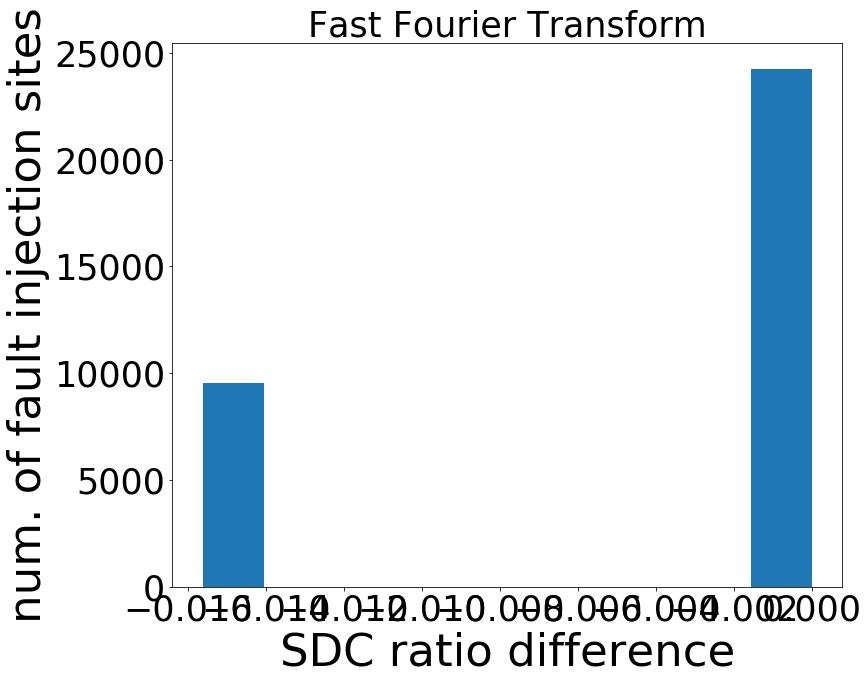

In [91]:
i=0
gap = -1
abs_result = golden_ratio_overtime[i:gap] - sdc_ratio_overtime_experiments[0][i:gap]
plt.figure(figsize=(12, 10))
#plt.subplot(131)
#plt.plot(golden_ratio_overtime[i:gap])
#plt.plot(sdc_ratio_overtime_experiments[0][i:gap])
#plt.subplot(132)
#plt.plot(abs_result)
#plt.subplot(133)
plt.hist(abs_result, bins = 10)
plt.xlabel('SDC ratio difference', fontsize=45)
plt.ylabel("num. of fault injection sites", fontsize=45)
plt.title('Fast Fourier Transform', fontsize=35)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)



plt.plot()

In [ ]:
print(abs_result[2067]>0)

### Mean and standard deviation

In [ ]:
print(np.mean(abs_result))
print(np.std(abs_result))

# Correlation Analysis - Granger Causality

Wiki: The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another

Use causality analysis to extract the propagation path and dependency relationship

# Inference Evaluation
1. We uniformly random sample 1000 experiments and use the masked cases to predict the first 5, 10, 20, 50, 100, 200, 300 corrupted instructions' outcome.

In [31]:
experiment_set=[50]#, 10, 20, 50, 100, 200, 300]
l = len(GOLDEN_RUN)

for knn in experiment_set:  
    prediction_accuracy = []
    prediction_amount = []
    for index, row in TEST_EXPERIMENTS.iterrows():
        #Ignore the SDC cases
        if float(row["diffnorm"]) > THRESHOLD:
            continue

        fault_inject_run = pd.read_csv(PROPAGATION_DATA_PATH+"/appstate_"+str(index)+".log",  sep=' ', names=['file', 'linenum', 'variable', 'value'])
        if len(fault_inject_run) < l:
            print("bad case!")
            continue
        else:
            fault_inject_run_value = np.array(fault_inject_run.value, dtype='float')[0:l] - np.array(GOLDEN_RUN.value, dtype='float')
            fault_inject_run_value = np.abs(fault_inject_run_value)

        prediction_index = np.where(fault_inject_run_value != 0)[0][1:1+knn]

        #if len(prediction_index) != 0:
            # where is the first data dependency element
        #    print(row['linenum'], '<-', fault_inject_run.iloc[prediction_index[0]]['linenum'])       
              
                
        if len(prediction_index) != knn:
            continue       
                
        prediction_result_accuracy = []
        preduction_result_amount = []
        for i in prediction_index:
            
            correct = 0
            incorrect = 0
            query_result = FAULT_INJECTION_CAMPAIGN[i*64:(i+1)*64]        

            for index, row in query_result.iterrows():
                inject_error = abs(float(row['init_value']) - float(row['corrupt_value']))
                diff = float(row['diffnorm'])

                if inject_error < fault_inject_run_value[i] and diff < THRESHOLD:
                    correct+=1
                elif inject_error < fault_inject_run_value[i] and diff >= THRESHOLD:
                    incorrect += 1
            if correct+incorrect == 0:
                prediction_result_accuracy.append(1)
                preduction_result_amount.append(0)
            else:
                #prediction_accuracy.append(correct/(correct+incorrect))
                #prediction_amount.append((correct + incorrect)/(knn * 64))
                prediction_result_accuracy.append(correct/(correct+incorrect))   
                preduction_result_amount.append((correct + incorrect)/ 64)
            
        print(prediction_result_accuracy)
        print(preduction_result_amount)
        print(prediction_index)
        #if correct+incorrect == 0:
        #    prediction_accuracy.append(1)
        #    prediction_amount.append(0)
        #else:
        #    prediction_accuracy.append(correct/(correct+incorrect))
        #    prediction_amount.append((correct + incorrect)/(knn * 64))


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.546875, 0.515625, 0.53125, 0.515625, 0.484375, 0.484375, 0.546875, 0.515625, 0.515625, 0.515625, 0.59375, 0.515625, 0.5, 0.4375, 0.484375, 0.4375, 0.515625, 0.515625, 0.484375, 0.546875, 0.515625, 0.515625, 0.5, 0.59375, 0.515625, 0.5, 0.4375, 0.484375, 0.4375, 0.515625, 0.515625, 0.53125, 0.515625, 0.515625, 0.546875, 0.5625, 0.5, 0.5, 0.4375, 0.484375, 0.4375, 0.515625, 0.515625, 0.59375, 0.515625, 0.5, 0.515625, 0.53125, 0.5, 0.390625]
[11567 11839 12111 12366 12620 12636 12652 12668 12684 12700 12716 12732
 12748 12764 12780 12796 12812 12828 12843 12858 12873 12888 12903 12918
 12933 12948 12963 12978 12993 13008 13023 13037 13051 13065 13079 13093
 13107 13121 13135 13149 13163 13177 13191 13204 13217 13230 13243 13256
 13269 1328

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.484375, 0.46875, 0.46875, 0.375, 0.390625, 0.34375, 0.390625, 0.375, 0.40625, 0.375, 0.328125, 0.421875, 0.421875, 0.359375, 0.375, 0.3125, 0.34375, 0.453125, 0.375, 0.3125, 0.390625, 0.375, 0.375, 0.390625, 0.4375, 0.390625, 0.390625, 0.359375, 0.390625, 0.3125, 0.375, 0.390625, 0.28125, 0.390625, 0.375, 0.375, 0.375, 0.4375, 0.390625, 0.390625, 0.359375, 0.390625, 0.3125, 0.375, 0.390625, 0.375, 0.375, 0.375, 0.421875, 0.40625]
[11550 11822 12094 12366 12383 12400 12417 12434 12451 12468 12485 12502
 12519 12536 12553 12570 12587 12604 12620 12636 12652 12668 12684 12700
 12716 12732 12748 12764 12780 12796 12812 12828 12843 12858 12873 12888
 12903 12918 12933 12948 12963 12978 12993 13008 13023 13037 13051 13065
 13079 13093]
[1.0, 

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.3125, 0.34375, 0.296875, 0.296875, 0.359375, 0.375, 0.375, 0.296875, 0.234375, 0.265625, 0.34375, 0.265625, 0.3125, 0.265625, 0.375, 0.359375, 0.328125, 0.265625, 0.328125, 0.3125, 0.265625, 0.390625, 0.28125, 0.265625, 0.375, 0.296875, 0.28125, 0.34375, 0.28125, 0.3125, 0.296875, 0.359375, 0.359375, 0.328125, 0.28125, 0.328125, 0.3125, 0.25, 0.390625, 0.265625, 0.265625, 0.296875, 0.296875, 0.28125, 0.34375, 0.28125, 0.3125, 0.28125, 0.359375, 0.34375]
[ 7918  7919  7965  7966  7967  7998  7999 12063 12064 12065 12066 12067
 12068 12069 12070 12071 12072 12073 12074 12075 12076 12077 12078 12079
 12335 12336 12337 12338 12339 12340 12341 12342 12343 12344 12345 12346
 12347 12348 12349 12350 12351 12590 12591 12592 12593 12594 12595 12

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.625, 0.625, 0.609375, 0.625, 0.625, 0.59375, 0.578125, 0.625, 0.609375, 0.578125, 0.609375, 0.53125, 0.59375, 0.515625, 0.609375, 0.5625, 0.578125, 0.578125, 0.578125, 0.546875, 0.609375, 0.625, 0.53125, 0.625, 0.5625, 0.515625, 0.578125, 0.671875, 0.59375, 0.578125, 0.59375, 0.59375, 0.5625, 0.53125, 0.578125, 0.578125, 0.578125, 0.578125, 0.53125, 0.578125, 0.59375, 0.578125, 0.609375, 0.578125, 0.578125, 0.546875, 0.640625, 0.578125, 0.546875, 0.5625]
[12407 12642 12848 13026 13027 13028 13029 13030 13031 13032 13033 13034
 13035 13036 13037 13038 13039 13194 13195 13196 13197 13198 13199 13200
 13201 13202 13203 13204 13205 13206 13207 13208 13209 13210 13211 13212
 13213 13214 13215 13216 13217 13218 13219 13220 13221 13222 13223 1

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.546875, 0.53125, 0.546875, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.546875, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.546875, 0.53125, 0.53125, 0.53125, 0.546875, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.546875]
[1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931
 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945
 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959
 1960 1961 1962 1963 1964 1965 1966 1967]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.3125, 0.25, 0.28125, 0.296875, 0.28125, 0.34375, 0.234375, 0.28125, 0.265625, 0.296875, 0.296875, 0.3125, 0.3125, 0.25, 0.28125, 0.34375, 0.25, 0.28125, 0.21875, 0.234375, 0.265625, 0.296875, 0.265625, 0.25, 0.25, 0.28125, 0.34375, 0.25, 0.28125, 0.21875, 0.234375, 0.265625, 0.28125, 0.265625, 0.28125, 0.28125, 0.265625, 0.296875, 0.28125, 0.234375, 0.28125, 0.25, 0.3125, 0.34375, 0.25, 0.25, 0.296875, 0.28125, 0.234375, 0.28125]
[13274 13275 13276 13277 13278 13279 13280 13281 13282 13283 13284 13397
 13398 13399 13400 13401 13402 13403 13404 13405 13406 13407 13408 13501
 13502 13503 13504 13505 13506 13507 13508 13509 13510 13511 13586 13587
 13588 13589 13590 13591 13592 13593 13594 13595 13654 13655 13656 13657
 13658 13659]
[1.0, 

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.5, 0.59375, 0.609375, 0.46875, 0.484375, 0.4375, 0.4375, 0.46875, 0.5, 0.515625, 0.453125, 0.46875, 0.4375, 0.484375, 0.59375, 0.59375, 0.625, 0.46875, 0.46875, 0.453125, 0.4375, 0.46875, 0.5, 0.515625, 0.4375, 0.46875, 0.40625, 0.5, 0.625, 0.625, 0.453125, 0.46875, 0.453125, 0.4375, 0.46875, 0.5, 0.515625, 0.4375, 0.46875, 0.421875, 0.484375, 0.46875, 0.46875, 0.46875, 0.46875, 0.421875, 0.46875, 0.5, 0.5, 0.3125]
[2603 2604 2605 2606 2607 2608 2609 2610 2611 2612 2613 2614 2615 2616
 2778 2779 2780 2781 2782 2783 2784 2785 2786 2787 2788 2789 2790 2791
 2929 2930 2931 2932 2933 2934 2935 2936 2937 2938 2939 2940 2941 3057
 3058 3059 3060 3061 3062 3063 3064 3065]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.359375, 0.375, 0.359375, 0.359375, 0.375, 0.359375, 0.359375, 0.359375, 0.359375, 0.359375, 0.359375, 0.359375, 0.375, 0.359375, 0.359375, 0.375, 0.359375, 0.359375, 0.359375, 0.359375, 0.359375, 0.359375, 0.359375, 0.359375, 0.375, 0.359375, 0.375, 0.359375, 0.359375, 0.359375, 0.359375, 0.359375, 0.359375, 0.375, 0.359375, 0.359375, 0.375, 0.375, 0.359375, 0.375, 0.359375, 0.359375, 0.359375, 0.359375, 0.359375, 0.359375, 0.359375, 0.359375, 0.375, 0.359375]
[1401 1402 1403 1404 1405 1406 1407 1408 1409 1410 1411 1412 1413 1414
 1415 1416 1417 1418 1419 1420 1421 1422 1423 1424 1425 1426 1427 1428
 1429 1430 1431 1432 1433 1434 1435 1436 1437 1438 1439 1440 1441 1442
 1443 1444 1445 1446 1447 1448 1449 1450]
[1.0, 1.0, 1.0, 1.0, 1.0, 

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.125, 0.109375, 0.109375, 0.125, 0.109375, 0.109375, 0.125, 0.125, 0.0625, 0.109375, 0.046875, 0.046875, 0.078125, 0.078125, 0.078125, 0.125, 0.078125, 0.09375, 0.0625, 0.03125, 0.046875, 0.09375, 0.078125, 0.09375, 0.03125, 0.109375, 0.046875, 0.0625, 0.109375, 0.078125, 0.09375, 0.09375, 0.046875, 0.078125, 0.09375, 0.09375, 0.03125, 0.09375, 0.078125, 0.0625, 0.125, 0.078125, 0.09375, 0.078125, 0.0625, 0.09375, 0.109375, 0.078125, 0.078125, 0.078125]
[ 7183  7338  7477  7600  7707  7798  7872  7873  7874  7875  7932  7933
  7934  7976  7977 11604 11605 11606 11607 11608 11609 11610 11611 11612
 11613 11614 11615 11616 11617 11618 11619 11620 11876 11877 11878 11879
 11880 11881 11882 11883 11884 11885 11886 11887 11888 11889 11890 118

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1.0, 1.0, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1.0, 1, 1.0, 1.0, 1, 1.0, 1.0, 1, 1, 1.0, 1.0, 1.0, 1, 1, 1.0, 1, 1, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.078125, 0.078125, 0.078125, 0.078125, 0.078125, 0.0625, 0.046875, 0.0625, 0.015625, 0, 0.03125, 0.015625, 0, 0.0625, 0.015625, 0.015625, 0.0625, 0.03125, 0.03125, 0.03125, 0.03125, 0, 0.046875, 0, 0.09375, 0.015625, 0, 0.0625, 0.015625, 0, 0, 0.015625, 0.046875, 0.078125, 0, 0, 0.046875, 0, 0, 0, 0.0625, 0.0625, 0.078125, 0.03125, 0.03125, 0.0625, 0.015625, 0.03125, 0.015625, 0.015625]
[ 7895  7949  7986  7987 12233 12240 12241 12244 12245 12247 12248 12490
 12492 12495 12496 12497 12499 12500 12502 12503 12722 12725 12726 12727
 12729 12730 12732 12733 12923 12925 12926 12927 12928 12930 12931 12933
 12934 12935 13098 13099 13104 13105 13108 13109 13248 13249 13250 13251
 13253 13256]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.703125, 0.671875, 0.671875, 0.6875, 0.515625, 0.5625, 0.609375, 0.578125, 0.640625, 0.453125, 0.578125, 0.625, 0.578125, 0.5625, 0.609375, 0.578125, 0.640625, 0.46875, 0.578125, 0.609375, 0.578125, 0.609375, 0.609375, 0.5, 0.53125, 0.53125, 0.53125, 0.578125, 0.5625, 0.53125, 0.59375, 0.59375, 0.53125, 0.453125, 0.53125, 0.59375, 0.578125, 0.578125, 0.53125, 0.640625, 0.640625, 0.5625, 0.5625, 0.484375, 0.609375, 0.65625, 0.5625, 0.546875, 0.5625, 0.5625]
[2579 2756 2908 3037 3156 3167 3178 3189 3200 3211 3222 3233 3244 3254
 3264 3274 3284 3294 3304 3314 3324 3332 3333 3334 3335 3336 3337 3338
 3339 3340 3341 3342 3343 3344 3345 3346 3347 3348 3349 3350 3351 3352
 3353 3354 3355 3356 3357 3358 3359 3360]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.34375, 0.1875, 0.15625, 0.25, 0.25, 0.1875, 0.1875, 0.15625, 0.25, 0.25, 0.171875, 0.171875, 0.265625, 0.265625, 0.25, 0.25, 0.28125, 0.28125, 0.28125, 0.34375, 0.359375, 0.21875, 0.234375, 0.25, 0.21875, 0.25, 0.234375, 0.234375, 0.15625, 0.265625, 0.203125, 0.1875, 0.21875, 0.171875, 0.25, 0.25, 0.1875, 0.421875, 0.21875, 0.234375, 0.25, 0.21875, 0.25, 0.21875, 0.234375, 0.15625, 0.265625, 0.203125, 0.1875, 0.21875]
[ 7759  7760  7761  7762  7763  7841  7842  7843  7844  7845  7908  7909
  7910  7911  7959  7960  7961  7994  7995 11213 11214 11215 11216 11217
 11218 11219 11220 11221 11222 11223 11224 11225 11226 11227 11228 11229
 11485 11486 11487 11488 11489 11490 11491 11492 11493 11494 11495 11496
 11497 11498]
[1.0, 1.0, 1.0, 1.

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.78125, 0.765625, 0.765625, 0.78125, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.78125, 0.78125, 0.765625, 0.765625, 0.78125, 0.78125, 0.765625, 0.765625, 0.78125, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625]
[1510 1511 1512 1513 1514 1515 1516 1517 1518 1519 1520 1521 1522 1523
 1524 1525 1526 1527 1528 1529 1530 1531 1532 1533 1534 1535 1536 1537
 1538 1539 1540 1541 1542 1543 1544 1545 1546 1547 1548 1549 1550 1551
 1552 1553 1554 1555 1556 1557 1558 1559]


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.34375, 0.34375, 0.390625, 0.375, 0.375, 0.421875, 0.4375, 0.4375, 0.296875, 0.34375, 0.28125, 0.3125, 0.296875, 0.25, 0.296875, 0.328125, 0.328125, 0.296875, 0.3125, 0.28125, 0.328125, 0.296875, 0.296875, 0.34375, 0.28125, 0.3125, 0.3125, 0.25, 0.296875, 0.3125, 0.3125, 0.296875, 0.3125, 0.265625, 0.328125, 0.34375, 0.34375, 0.296875, 0.28125, 0.359375, 0.3125, 0.296875, 0.296875, 0.328125, 0.328125, 0.28125, 0.28125, 0.203125, 0.3125, 0.3125]
[11505 11777 12049 12321 12576 12801 12996 12997 12998 12999 13000 13001
 13002 13003 13004 13005 13006 13007 13008 13009 13010 13166 13167 13168
 13169 13170 13171 13172 13173 13174 13175 13176 13177 13178 13179 13311
 13312 13313 13314 13315 13316 13317 13318 13319 13320 13321 13322 13323
 13433

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625]
[1201 1202 1203 1204 1205 1206 1207 1208 1209 1210 1211 1212 1213 1214
 1215 1216 1217 1218 1219 1220 1221 1222 1223 1224 1225 1226 1227 1228
 1229 1230 1231 1232 1233 1234 1235 1236 1237 1238 1239 1240 1241 1242
 1243 1244 1245 1246 1247 1248 1249 1250]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.078125, 0.078125, 0.109375, 0.109375, 0.078125, 0.03125, 0.0625, 0.0625, 0.09375, 0, 0.03125, 0.015625, 0.046875, 0.0625, 0.0625, 0.109375, 0.015625, 0.03125, 0, 0.046875, 0.0625, 0.109375, 0.015625, 0.015625, 0, 0.0625, 0.109375, 0.015625, 0.03125, 0.03125, 0.125, 0.015625, 0.015625, 0.046875, 0.0625, 0.046875, 0, 0.078125, 0.03125, 0.0625, 0.015625, 0.078125, 0.046875, 0.0625, 0.125, 0.0625, 0.0625, 0.046875, 0.125, 0.0625]
[2777 2928 3056 3163 3261 3271 3281 3291 3301 3311 3321 3331 3340 3349
 3358 3367 3376 3385 3394 3402 3410 3418 3426 3434 3442 3449 3456 3463
 3470 3477 3483 3489 3495 3506 3511 3520 3524 7145 7155 7165 7175 7185
 7195 7205 7215 7235 7245 7255 7265 7275]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.1875, 0.1875, 0.203125, 0.203125, 0.1875, 0.1875, 0.1875, 0, 0.046875, 0.125, 0.09375, 0.046875, 0.125, 0.09375, 0.03125, 0.03125, 0.125, 0.09375, 0.125, 0.125, 0.078125, 0.1875, 0.171875, 0.15625, 0.109375, 0.140625, 0.078125, 0.140625, 0.09375, 0.09375, 0.046875, 0.21875, 0.0625, 0.078125, 0.109375, 0.0625, 0.109375, 0.125, 0.15625, 0.15625, 0.109375, 0.140625, 0.078125, 0.140625, 0.09375, 0.09375, 0.015625, 0.171875, 0.0625, 0.078125]
[3236 3317 3381 3430 3466 3490 3491 3492 3493 3494 3495 3509 3510 3511
 3517 3518 3519 3520 3525 3526 3527 5432 5433 5434 5435 5436 5437 5438
 5439 5440 5441 5442 5443 5444 5445 5446 5447 5448 5484 5485 5486 5487
 5488 5489 5490 5491 5492 5493 5494 5495]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625]
[1482 1483 1484 1485 1486 1487 1488 1489 1490 1491 1492 1493 1494 1495
 1496 1497 1498 1499 1500 1501 1502 1503 1504 1505 1506 1507 1508 1509
 1510 1511 1512 1513 1514 1515 1516 1517 1518 1519 1520 1521 1522 1523
 1524 1525 1526 1527 1528 1529 1530

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1.0, 1.0, 1.0, 1.0, 1, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0625, 0.0625, 0.015625, 0.015625, 0.015625, 0.015625, 0.0625, 0.015625, 0.03125, 0.03125, 0, 0.015625, 0.046875, 0.03125, 0.046875, 0, 0, 0.03125, 0.015625, 0.03125, 0.03125, 0.015625, 0.03125, 0.046875, 0.015625, 0.015625, 0.015625, 0.015625, 0.0625, 0.046875, 0.015625, 0.078125, 0.015625, 0.046875, 0.03125, 0.015625, 0.03125, 0.015625, 0, 0.015625, 0.015625, 0.03125, 0.046875, 0.03125, 0.03125, 0.03125, 0.03125, 0.015625, 0.046875, 0.078125]
[ 7740  7741  7744  7830  7899  7952 11162 11165 11169 11174 11437 11438
 11446 11709 11983 11987 11990 11992 11994 12254 12255 12259 12262 12264
 12266 12509 12510 12514 12517 12519 12521 12739 12750 12939 12946 12950
 13112 13119 13123 13259 13260 13261 13267 13270 13271 13385 13386 13387
 13389 13395]


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.34375, 0.3125, 0.328125, 0.328125, 0.328125, 0.28125, 0.25, 0.265625, 0.28125, 0.296875, 0.265625, 0.28125, 0.28125, 0.296875, 0.28125, 0.296875, 0.265625, 0.265625, 0.25, 0.296875, 0.25, 0.28125, 0.28125, 0.265625, 0.265625, 0.28125, 0.265625, 0.25, 0.28125, 0.265625, 0.28125, 0.296875, 0.296875, 0.265625, 0.265625, 0.25, 0.296875, 0.234375, 0.25, 0.25, 0.265625, 0.265625, 0.203125, 0.1875, 0.359375, 0.265625, 0.28125, 0.328125, 0.28125, 0.28125]
[ 7875  7934  7976  7977 12148 12149 12150 12151 12152 12153 12154 12155
 12156 12157 12158 12159 12160 12161 12162 12163 12164 12403 12404 12405
 12406 12407 12408 12409 12410 12411 12412 12413 12414 12415 12416 12417
 12418 12419 12639 12640 12641 12642 12643 12644 12645 12646 12647 12648
 1

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.125, 0.140625, 0.125, 0.140625, 0.125, 0.140625, 0.140625, 0.140625, 0.140625, 0.140625, 0.125, 0.109375, 0.125, 0.1875, 0.15625, 0.140625, 0.0625, 0.109375, 0.140625, 0.0625, 0.109375, 0.125, 0.125, 0.09375, 0.15625, 0.125, 0.078125, 0.109375, 0.15625, 0.09375, 0.109375, 0.125, 0.09375, 0.1875, 0.15625, 0.09375, 0.125, 0.15625, 0.109375, 0.109375, 0.140625, 0.109375, 0.109375, 0.09375, 0.09375, 0.140625, 0.09375, 0.109375, 0.109375, 0.109375]
[10527 10799 11071 11343 11615 11887 12159 12414 12649 12855 13034 13201
 13214 13227 13240 13253 13266 13279 13292 13305 13318 13331 13343 13355
 13367 13379 13391 13403 13415 13427 13439 13451 13462 13473 13484 13495
 13506 13517 13528 13539 13550 13560 13570 13580 13590 13600 13610 13620
 13630

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.546875, 0.53125, 0.53125, 0.546875, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.546875, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.546875, 0.53125, 0.546875, 0.546875, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.546875, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.53125, 0.546875, 0.53125, 0.53125]
[1797 1798 1799 1800 1801 1802 1803 1804 1805 1806 1807 1808 1809 1810
 1811 1812 1813 1814 1815 1816 1817 1818 1819 1820 1821 1822 1823 1824
 1825 1826 1827 1828 1829 1830 1831 1832 1833 1834 1835 1836 1837 1838
 1839 1840 1841 1842 1843 1844 1845 1846]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.34375, 0.359375, 0.359375, 0.3125, 0.328125, 0.34375, 0.3125, 0.28125, 0.3125, 0.359375, 0.28125, 0.328125, 0.234375, 0.28125, 0.3125, 0.296875, 0.328125, 0.328125, 0.34375, 0.34375, 0.3125, 0.296875, 0.3125, 0.359375, 0.28125, 0.34375, 0.234375, 0.28125, 0.265625, 0.3125, 0.34375, 0.34375, 0.34375, 0.296875, 0.3125, 0.3125, 0.375, 0.28125, 0.34375, 0.234375, 0.28125, 0.28125, 0.3125, 0.359375, 0.359375, 0.296875, 0.3125, 0.3125, 0.390625, 0.28125]
[5874 6126 6127 6128 6129 6130 6131 6132 6133 6134 6135 6136 6137 6138
 6139 6140 6364 6365 6366 6367 6368 6369 6370 6371 6372 6373 6374 6375
 6376 6377 6586 6587 6588 6589 6590 6591 6592 6593 6594 6595 6596 6597
 6598 6792 6793 6794 6795 6796 6797 6798]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.46875, 0.46875, 0.5, 0.40625, 0.484375, 0.515625, 0.421875, 0.515625, 0.515625, 0.46875, 0.46875, 0.484375, 0.453125, 0.5, 0.515625, 0.46875, 0.5, 0.5, 0.46875, 0.46875, 0.515625, 0.421875, 0.515625, 0.515625, 0.421875, 0.421875, 0.453125, 0.453125, 0.5, 0.515625, 0.484375, 0.453125, 0.453125, 0.484375, 0.515625, 0.421875, 0.5625, 0.5, 0.4375, 0.421875, 0.453125, 0.453125, 0.484375, 0.5, 0.484375, 0.484375, 0.484375, 0.515625, 0.4375, 0.5625]
[5984 5985 5986 5987 5988 5989 5990 5991 5992 5993 5994 5995 5996 5997
 5998 5999 6231 6232 6233 6234 6235 6236 6237 6238 6239 6240 6241 6242
 6243 6244 6245 6462 6463 6464 6465 6466 6467 6468 6469 6470 6471 6472
 6473 6474 6475 6677 6678 6679 6680 6681]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.296875, 0.296875, 0.34375, 0.34375, 0.328125, 0.328125, 0.34375, 0.3125, 0.265625, 0.265625, 0.265625, 0.28125, 0.28125, 0.296875, 0.21875, 0.265625, 0.25, 0.25, 0.3125, 0.21875, 0.28125, 0.28125, 0.28125, 0.234375, 0.265625, 0.265625, 0.25, 0.3125, 0.21875, 0.265625, 0.21875, 0.21875, 0.21875, 0.234375, 0.203125, 0.21875, 0.25, 0.25, 0.234375, 0.234375, 0.234375, 0.171875, 0.1875, 0.1875, 0.15625, 0.25, 0.234375, 0.234375, 0.234375, 0.203125]
[11425 11697 11969 12241 12496 12726 12927 13101 13250 13376 13481 13566
 13567 13568 13569 13570 13571 13572 13573 13574 13575 13636 13637 13638
 13639 13640 13641 13642 13643 13644 13699 13700 13701 13702 13703 13704
 13705 13706 13707 13708 13709 13710 13711 13712 13713 13714 13715 13716
 13717

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.78125, 0.765625, 0.765625, 0.78125, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.78125, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.765625, 0.78125, 0.765625, 0.765625, 0.78125, 0.765625, 0.78125, 0.78125, 0.78125, 0.78125, 0.78125, 0.78125]
[1144 1145 1146 1147 1148 1149 1150 1151 1152 1153 1154 1155 1156 1157
 1158 1159 1160 1161 1162 1163 1164 1165 1166 1167 1168 1169 1170 1171
 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181 1182 1183 1184 1185
 1186 1187 1188 1189 1190 1191 1192 1193]
[1.0

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.578125, 0.59375, 0.59375, 0.53125, 0.609375, 0.53125, 0.5625, 0.578125, 0.546875, 0.59375, 0.59375, 0.546875, 0.5625, 0.546875, 0.578125, 0.59375, 0.59375, 0.59375, 0.546875, 0.515625, 0.609375, 0.53125, 0.578125, 0.578125, 0.546875, 0.59375, 0.609375, 0.5625, 0.5625, 0.578125, 0.578125, 0.609375, 0.59375, 0.59375, 0.546875, 0.59375, 0.53125, 0.578125, 0.5625, 0.546875, 0.609375, 0.609375, 0.5625, 0.578125, 0.578125, 0.578125, 0.59375, 0.59375, 0.59375, 0.546875]
[ 5499  5533  5567 11824 11841 11858 11875 11892 11909 11926 11943 11960
 11977 11994 12011 12028 12045 12062 12079 12096 12113 12130 12147 12164
 12181 12198 12215 12232 12249 12266 12283 12300 12317 12334 12351 12368
 12385 12402 12419 12436 12453 12470 12487 12504 12521 1253

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.171875, 0.171875, 0.171875, 0.171875, 0.171875, 0.171875, 0.171875, 0.171875, 0.171875, 0.1875, 0.171875, 0.1875, 0.171875, 0.1875, 0.171875, 0.171875, 0.171875, 0.171875, 0.1875, 0.171875, 0.171875, 0.1875, 0.171875, 0.171875, 0.171875, 0.171875, 0.1875, 0.171875, 0.171875, 0.171875, 0.1875, 0.171875, 0.171875, 0.171875, 0.171875, 0.171875, 0.171875, 0.171875, 0.171875, 0.171875, 0.1875, 0.171875, 0.171875, 0.171875, 0.171875, 0.1875, 0.171875, 0.171875, 0.171875, 0.171875]
[1596 1597 1598 1599 1600 1601 1602 1603 1604 1605 1606 1607 1608 1609
 1610 1611 1612 1613 1614 1615 1616 1617 1618 1619 1620 1621 1622 1623
 1624 1625 1626 1627 1628 1629 1630 1631 1632 1633 1634 1635 1636 1637
 1638 1639 1640 1641 1642 1643 1644 1645]
[1.0, 1.0, 

[1.0, 1.0, 1.0, 1.0, 1.0, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1.0, 1.0, 1.0, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1.0, 1.0, 1.0, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1.0, 1.0]
[0.03125, 0.0625, 0.046875, 0.078125, 0.015625, 0, 0.015625, 0.046875, 0.125, 0.015625, 0.0625, 0.046875, 0.015625, 0.015625, 0, 0.078125, 0.015625, 0.078125, 0, 0.046875, 0.078125, 0.0625, 0.078125, 0.015625, 0.046875, 0.046875, 0.09375, 0.0625, 0.078125, 0.03125, 0.046875, 0, 0.046875, 0.046875, 0.046875, 0, 0.078125, 0.015625, 0.078125, 0.046875, 0.109375, 0.03125, 0.046875, 0.0625, 0.046875, 0.0625, 0.046875, 0, 0.015625, 0.0625]
[ 9906  9907  9911  9912  9915  9916  9917  9918 10179 10181 10183 10184
 10187 10188 10189 10190 10450 10451 10453 10455 10456 10459 10462 10722
 10723 10727 10728 10731 10734 10994 10995 10997 10999 11000 11003 11005
 11006 11266 11267 11271 11272 11275 11278 11539 11543 11547 11550 11810
 11811 11815]
[1.0, 1.0, 1.0, 1

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1.0, 1.0, 1.0, 1.0]
[0.15625, 0.15625, 0.125, 0.125, 0.125, 0.15625, 0.078125, 0.125, 0.15625, 0.046875, 0.15625, 0.078125, 0.15625, 0.140625, 0.140625, 0.078125, 0.15625, 0.109375, 0.171875, 0.140625, 0.125, 0.125, 0.125, 0.125, 0.109375, 0.15625, 0.078125, 0.15625, 0.03125, 0.15625, 0.140625, 0.140625, 0.0625, 0.21875, 0.125, 0.25, 0.140625, 0.125, 0.125, 0.125, 0.125, 0.109375, 0.15625, 0.078125, 0.15625, 0, 0.15625, 0.140625, 0.140625, 0.0625]
[ 7929  7930  7931  7974  7975 11859 11860 11861 11862 11863 11864 11865
 11866 11867 11868 11869 11870 11871 11872 11873 11874 11875 12131 12132
 12133 12134 12135 12136 12137 12138 12139 12140 12141 12142 12143 12144
 12145 12146 12147 12386 12387 12388 12389 12390 12391 12392 12393 12394
 12395 12396]
[1.0, 1.0, 1.

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.34375, 0.296875, 0.296875, 0.265625, 0.3125, 0.28125, 0.328125, 0.296875, 0.296875, 0.265625, 0.3125, 0.28125, 0.328125, 0.296875, 0.265625, 0.3125, 0.28125, 0.328125, 0.296875, 0.3125, 0.28125, 0.328125, 0.296875, 0.28125, 0.296875, 0.296875, 0.34375, 0.296875, 0.296875, 0.21875, 0.28125, 0.265625, 0.296875, 0.3125, 0.296875, 0.328125, 0.296875, 0.34375, 0.265625, 0.265625, 0.3125, 0.28125, 0.375, 0.34375, 0.28125, 0.21875, 0.28125, 0.265625, 0.296875, 0.3125]
[ 4957  5093  5110  5127  5144  5161  5178  5195  5212  5229  5246  5263
  5280  5297  5314  5331  5348  5365  5382  5399  5416  5433  5450  5467
  5484  5501  5518  5535  5552 10177 10194 10211 10228 10245 10262 10279
 10296 10313 10330 10347 10364 10381 10398 10415 10432 10449 

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.390625, 0.375, 0.375, 0.375, 0.390625, 0.375, 0.390625, 0.375, 0.375, 0.40625, 0.296875, 0.34375, 0.296875, 0.3125, 0.40625, 0.3125, 0.40625, 0.40625, 0.296875, 0.34375, 0.296875, 0.3125, 0.40625, 0.3125, 0.3125, 0.3125, 0.328125, 0.296875, 0.3125, 0.40625, 0.3125, 0.328125, 0.328125, 0.296875, 0.3125, 0.390625, 0.3125, 0.296875, 0.296875, 0.3125, 0.375, 0.3125, 0.3125, 0.3125, 0.359375, 0.296875, 0.359375, 0.359375, 0.328125, 0.34375]
[5880 6133 6370 6591 6796 6985 7158 7314 7315 7316 7317 7318 7319 7320
 7321 7322 7456 7457 7458 7459 7460 7461 7462 7463 7582 7583 7584 7585
 7586 7587 7588 7692 7693 7694 7695 7696 7697 7786 7787 7788 7789 7790
 7864 7865 7866 7867 7926 7927 7928 7972]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.609375, 0.578125, 0.546875, 0.546875, 0.546875, 0.546875, 0.5625, 0.578125, 0.515625, 0.53125, 0.515625, 0.515625, 0.5, 0.609375, 0.546875, 0.484375, 0.5625, 0.53125, 0.53125, 0.5, 0.453125, 0.484375, 0.5, 0.546875, 0.53125, 0.5, 0.609375, 0.546875, 0.484375, 0.578125, 0.53125, 0.53125, 0.5, 0.453125, 0.484375, 0.5, 0.546875, 0.515625, 0.5625, 0.546875, 0.484375, 0.53125, 0.53125, 0.515625, 0.5, 0.453125, 0.484375, 0.5, 0.546875, 0.53125]
[ 9656  9928 10200 10472 10744 11016 11288 11560 11832 12104 12359 12613
 12629 12645 12661 12677 12693 12709 12725 12741 12757 12773 12789 12805
 12821 12836 12851 12866 12881 12896 12911 12926 12941 12956 12971 12986
 13001 13016 13030 13044 13058 13072 13086 13100 13114 13128 13142 13156
 13170 1318

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1.0, 1.0, 1.0, 1.0]
[0.09375, 0.109375, 0.109375, 0.109375, 0.109375, 0.109375, 0.03125, 0.09375, 0.015625, 0.015625, 0.0625, 0, 0, 0.109375, 0.09375, 0.078125, 0.015625, 0.03125, 0.015625, 0.0625, 0.078125, 0, 0.046875, 0.046875, 0.0625, 0.109375, 0.046875, 0.046875, 0.0625, 0.015625, 0.09375, 0.078125, 0.125, 0.015625, 0.15625, 0.078125, 0.109375, 0.0625, 0.0625, 0.078125, 0.109375, 0.078125, 0.125, 0.03125, 0.078125, 0, 0.078125, 0.078125, 0.125, 0.125]
[ 7493  7614  7719  7808  7880  7881  7882  7883  7938  7939  7940  7980
  7981 11638 11639 11640 11641 11642 11643 11644 11646 11647 11648 11649
 11650 11651 11652 11653 11654 11910 11911 11912 11913 11914 11915 11916
 11918 11919 11920 11921 11922 11923 11924 11925 11926 12182 12183 12184
 12185 12187]
[1.0, 1.0,

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.46875, 0.453125, 0.46875, 0.453125, 0.453125, 0.453125, 0.46875, 0.453125, 0.453125, 0.46875, 0.46875, 0.453125, 0.453125, 0.453125, 0.390625, 0.359375, 0.359375, 0.453125, 0.40625, 0.390625, 0.40625, 0.390625, 0.375, 0.359375, 0.359375, 0.421875, 0.375, 0.375, 0.40625, 0.375, 0.375, 0.375, 0.390625, 0.359375, 0.46875, 0.375, 0.390625, 0.40625, 0.375, 0.375, 0.359375, 0.359375, 0.453125, 0.359375, 0.375, 0.40625, 0.375, 0.375, 0.375, 0.3125]
[ 6702  6899  7080  7245  7394  7527  7644  7745  7830  7899  7952  7988
  7989 12250 12251 12252 12253 12254 12255 12256 12257 12258 12259 12260
 12261 12262 12263 12264 12265 12266 12505 12506 12507 12508 12509 12510
 12511 12512 12513 12514 12515 12516 12517 12518 12519 12520 12521 12735
 12736 1

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.21875, 0.21875, 0.203125, 0.203125, 0.203125, 0.21875, 0.203125, 0.21875, 0.203125, 0.15625, 0.09375, 0.15625, 0.171875, 0.1875, 0.0625, 0.1875, 0.1875, 0.171875, 0.171875, 0.125, 0.109375, 0.125, 0.109375, 0.15625, 0.171875, 0.21875, 0.109375, 0.234375, 0.1875, 0.171875, 0.171875, 0.109375, 0.03125, 0.125, 0.140625, 0.171875, 0.171875, 0.109375, 0.125, 0.1875, 0.171875, 0.125, 0.109375, 0.078125, 0.109375, 0.15625, 0.15625, 0.109375, 0.203125, 0.203125]
[10498 10770 11042 11314 11586 11858 12130 12385 12622 12845 12860 12875
 12890 12905 12920 12935 12950 12965 12980 12995 13010 13025 13039 13053
 13067 13081 13095 13109 13123 13137 13151 13165 13179 13193 13206 13219
 13232 13245 13258 13271 13284 13297 13310 13323 13336 13348 13360 1

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.28125, 0.296875, 0.28125, 0.28125, 0.328125, 0.328125, 0.328125, 0.3125, 0.328125, 0.296875, 0.25, 0.265625, 0.25, 0.265625, 0.265625, 0.28125, 0.203125, 0.25, 0.234375, 0.234375, 0.296875, 0.203125, 0.265625, 0.265625, 0.265625, 0.21875, 0.25, 0.25, 0.234375, 0.296875, 0.203125, 0.25, 0.203125, 0.203125, 0.203125, 0.21875, 0.1875, 0.203125, 0.234375, 0.234375, 0.21875, 0.21875, 0.21875, 0.15625, 0.171875, 0.171875, 0.140625, 0.234375, 0.21875, 0.21875]
[10881 11153 11425 11697 11969 12241 12496 12726 12927 13101 13250 13376
 13481 13566 13567 13568 13569 13570 13571 13572 13573 13574 13575 13636
 13637 13638 13639 13640 13641 13642 13643 13644 13699 13700 13701 13702
 13703 13704 13705 13706 13707 13708 13709 13710 13711 13712 13713 13

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.328125, 0.328125, 0.328125, 0.34375, 0.359375, 0.34375, 0.328125, 0.328125, 0.34375, 0.34375, 0.328125, 0.34375, 0.34375, 0.28125, 0.328125, 0.265625, 0.265625, 0.296875, 0.296875, 0.296875, 0.34375, 0.328125, 0.3125, 0.265625, 0.28125, 0.265625, 0.3125, 0.265625, 0.3125, 0.25, 0.28125, 0.28125, 0.296875, 0.34375, 0.28125, 0.28125, 0.296875, 0.265625, 0.328125, 0.3125, 0.359375, 0.265625, 0.390625, 0.3125, 0.25, 0.34375, 0.3125, 0.296875, 0.3125, 0.34375]
[ 6198  6431  6648  6849  7034  7203  7356  7493  7614  7719  7808  7880
  7881  7882  7883  7938  7939  7940  7980  7981 11638 11639 11640 11641
 11642 11643 11644 11645 11646 11647 11648 11649 11650 11651 11652 11653
 11654 11910 11911 11912 11913 11914 11915 11916 11917 11918 11919 

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.359375, 0.359375, 0.359375, 0.375, 0.359375, 0.359375, 0.359375, 0.359375, 0.375, 0.359375, 0.359375, 0.359375, 0.359375, 0.359375, 0.375, 0.375, 0.375, 0.359375, 0.375, 0.359375, 0.359375, 0.375, 0.359375, 0.359375, 0.359375, 0.359375, 0.375, 0.359375, 0.359375, 0.359375, 0.375, 0.375, 0.359375, 0.359375, 0.359375, 0.359375, 0.375, 0.359375, 0.375, 0.375, 0.359375, 0.359375, 0.359375, 0.359375, 0.359375, 0.359375, 0.359375, 0.359375, 0.375, 0.359375]
[1335 1336 1337 1338 1339 1340 1341 1342 1343 1344 1345 1346 1347 1348
 1349 1350 1351 1352 1353 1354 1355 1356 1357 1358 1359 1360 1361 1362
 1363 1364 1365 1366 1367 1368 1369 1370 1371 1372 1373 1374 1375 1376
 1377 1378 1379 1380 1381 1382 1383 1384]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.765625, 0.75, 0.75, 0.75, 0.75, 0.765625, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.765625, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75]
[1760 1761 1762 1763 1764 1765 1766 1767 1768 1769 1770 1771 1772 1773
 1774 1775 1776 1777 1778 1779 1780 1781 1782 1783 1784 1785 1786 1787
 1788 1789 1790 1791 1792 1793 1794 1795 1796 1797 1798 1799 1800 1801
 1802 1803 1804 1805 1806 1807 1808 1809]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

[1.0, 1.0, 1.0, 1.0, 1.0, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1.0, 1, 1.0, 1.0, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1.0, 1.0, 1.0, 1, 1.0, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1.0]
[0.015625, 0.015625, 0.015625, 0.015625, 0.03125, 0, 0.046875, 0.015625, 0.046875, 0.015625, 0.046875, 0.046875, 0.0625, 0.015625, 0.03125, 0.078125, 0.015625, 0.09375, 0, 0.109375, 0, 0.109375, 0.046875, 0, 0.03125, 0.078125, 0.046875, 0.046875, 0.09375, 0.046875, 0, 0.015625, 0.109375, 0.015625, 0, 0.109375, 0, 0.0625, 0.03125, 0.015625, 0.015625, 0.09375, 0.015625, 0.015625, 0.03125, 0.046875, 0.046875, 0.015625, 0, 0.046875]
[6653 6852 6853 6856 6857 6859 6860 6862 6863 7040 7044 7045 7047 7208
 7211 7212 7214 7215 7363 7364 7366 7367 7500 7501 7502 7503 7620 7622
 7623 7724 7725 7726 7727 7813 7814 7815 7886 7887 7943 9479 9480 9481
 9492 9495 9752 9753 9754 9762 9764 9767]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.078125, 0.078125, 0.09375, 0.078125, 0.078125, 0.078125, 0.078125, 0.078125, 0.078125, 0.078125, 0.09375, 0.078125, 0.078125, 0.109375, 0.125, 0.125, 0.1875, 0.171875, 0.171875, 0.1875, 0.1875, 0.109375, 0.046875, 0.109375, 0.125, 0.09375, 0.109375, 0.109375, 0.109375, 0.015625, 0.109375, 0.109375, 0.109375, 0.109375, 0.0625, 0.109375, 0.09375, 0.0625, 0.0625, 0.0625, 0.046875, 0, 0.140625, 0.09375, 0.0625, 0.0625, 0.09375, 0.078125, 0.09375, 0.0625]
[ 8498  8770  9042  9314  9586  9858 10130 10402 10674 10946 11218 11490
 11762 12034 12306 12561 12787 12984 13154 13298 13299 13300 13301 13302
 13303 13304 13305 13306 13307 13308 13309 13310 13421 13422 13423 13424
 13425 13426 13427 13428 13429 13430 13431 13432 13523 13524 13525 13526
 

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.125, 0.0625, 0.09375, 0.15625, 0.09375, 0.140625, 0.0625, 0.078125, 0.09375, 0.140625, 0.09375, 0.140625, 0.0625, 0.078125, 0.140625, 0.09375, 0.140625, 0.0625, 0.078125, 0.09375, 0.140625, 0.0625, 0.078125, 0.140625, 0.046875, 0.078125, 0.0625, 0.078125, 0.109375, 0.09375, 0.09375, 0.09375, 0.125, 0.078125, 0.125, 0.09375, 0.109375, 0.046875, 0.078125, 0.09375, 0.09375, 0.09375, 0.0625, 0.09375, 0.0625, 0.09375, 0.09375, 0.09375, 0.125, 0.078125]
[ 4965  5101  5118  5135  5152  5169  5186  5203  5220  5237  5254  5271
  5288  5305  5322  5339  5356  5373  5390  5407  5424  5441  5458  5475
  5492  5509  5526  5543  5560 10185 10202 10219 10236 10253 10270 10287
 10304 10321 10338 10355 10372 10389 10406 10423 10440 10457 10474 10491
 1

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.171875, 0.1875, 0.1875, 0.171875, 0.171875, 0.1875, 0.203125, 0.15625, 0.171875, 0.15625, 0.25, 0.1875, 0.125, 0.171875, 0.15625, 0.1875, 0.1875, 0.1875, 0.15625, 0.171875, 0.15625, 0.25, 0.1875, 0.125, 0.15625, 0.15625, 0.171875, 0.171875, 0.15625, 0.1875, 0.15625, 0.25, 0.1875, 0.125, 0.15625, 0.15625, 0.15625, 0.15625, 0.171875, 0.15625, 0.203125, 0.203125, 0.125, 0.1875, 0.15625, 0.171875, 0.171875, 0.140625, 0.203125, 0.203125]
[2681 2851 2996 3117 3118 3119 3120 3121 3122 3123 3124 3125 3126 3127
 3128 3219 3220 3221 3222 3223 3224 3225 3226 3227 3228 3229 3302 3303
 3304 3305 3306 3307 3308 3309 3310 3311 3368 3369 3370 3371 3372 3373
 3374 3375 3376 3419 3420 3421 3422 3423]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.171875, 0.171875, 0.171875, 0.1875, 0.171875, 0.171875, 0.171875, 0.1875, 0.171875, 0.171875, 0.171875, 0.21875, 0.203125, 0.203125, 0.203125, 0.21875, 0.1875, 0.234375, 0.171875, 0.1875, 0.15625, 0.203125, 0.171875, 0.109375, 0.234375, 0.125, 0.203125, 0.1875, 0.1875, 0.171875, 0.171875, 0.171875, 0.1875, 0.15625, 0.21875, 0.1875, 0.265625, 0.171875, 0.171875, 0.171875, 0.1875, 0.1875, 0.171875, 0.203125, 0.1875, 0.25, 0.171875, 0.171875, 0.171875, 0.140625]
[ 8892  9164  9436  9708  9980 10252 10524 10796 11068 11340 11612 11884
 12156 12411 12646 12852 13031 13198 13211 13224 13237 13250 13263 13276
 13289 13302 13315 13328 13340 13352 13364 13376 13388 13400 13412 13424
 13436 13448 13459 13470 13481 13492 13503 13514 13525 13536 13

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.40625, 0.390625, 0.390625, 0.390625, 0.390625, 0.40625, 0.40625, 0.40625, 0.40625, 0.390625, 0.40625, 0.421875, 0.4375, 0.4375, 0.4375, 0.359375, 0.328125, 0.359375, 0.359375, 0.328125, 0.359375, 0.390625, 0.375, 0.359375, 0.34375, 0.390625, 0.359375, 0.328125, 0.375, 0.359375, 0.296875, 0.359375, 0.359375, 0.34375, 0.359375, 0.359375, 0.3125, 0.34375, 0.390625, 0.34375, 0.359375, 0.328125, 0.390625, 0.34375, 0.328125, 0.390625, 0.359375, 0.296875, 0.328125, 0.328125]
[ 6559  6767  6959  7135  7295  7439  7567  7679  7775  7855  7919  7967
  7998  7999 12335 12336 12337 12338 12339 12340 12341 12342 12343 12344
 12345 12346 12347 12348 12349 12350 12351 12590 12591 12592 12593 12594
 12595 12596 12597 12598 12599 12600 12601 12602 12603

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.15625, 0.140625, 0.1875, 0.109375, 0.171875, 0.1875, 0.203125, 0.203125, 0.1875, 0.15625, 0.21875, 0.15625, 0.171875, 0.203125, 0.15625, 0.28125, 0.171875, 0.171875, 0.1875, 0.109375, 0.171875, 0.171875, 0.1875, 0.203125, 0.1875, 0.15625, 0.203125, 0.15625, 0.1875, 0.203125, 0.15625, 0.21875, 0.171875, 0.203125, 0.1875, 0.109375, 0.171875, 0.171875, 0.1875, 0.203125, 0.1875, 0.15625, 0.203125, 0.15625, 0.1875, 0.203125, 0.15625, 0.1875, 0.171875, 0.1875]
[9140 9141 9142 9143 9144 9145 9146 9147 9148 9149 9150 9151 9152 9153
 9154 9155 9412 9413 9414 9415 9416 9417 9418 9419 9420 9421 9422 9423
 9424 9425 9426 9427 9684 9685 9686 9687 9688 9689 9690 9691 9692 9693
 9694 9695 9696 9697 9698 9699 9956 9957]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.515625, 0.515625, 0.4375, 0.421875, 0.46875, 0.46875, 0.453125, 0.421875, 0.53125, 0.4375, 0.484375, 0.421875, 0.484375, 0.484375, 0.421875, 0.4375, 0.484375, 0.4375, 0.4375, 0.359375, 0.4375, 0.4375, 0.4375, 0.421875, 0.4375, 0.46875, 0.46875, 0.390625, 0.40625, 0.421875, 0.40625, 0.390625, 0.40625, 0.4375, 0.4375, 0.421875, 0.375]
[ 8834  9106  9378  9650  9922 10194 10466 10738 11010 11282 11554 11826
 12098 12352 12353 12354 12355 12356 12357 12358 12359 12360 12361 12362
 12363 12364 12365 12366 12367 12368 12607 12608 12609 12610 12611 12612
 12613 12614 12615 12616 12617 12618 12619 12620 12621 12622 12623 12624
 12625 12626]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.65625, 0.65625, 0.5625, 0.5, 0.515625, 0.53125, 0.546875, 0.5625, 0.5625, 0.5, 0.515625, 0.515625, 0.53125, 0.484375, 0.484375, 0.5, 0.5, 0.546875, 0.515625, 0.515625, 0.5, 0.53125, 0.5, 0.5, 0.546875, 0.546875, 0.546875, 0.65625, 0.515625, 0.53125, 0.578125, 0.546875, 0.5625, 0.546875, 0.578125, 0.53125, 0.546875, 0.578125, 0.5625, 0.59375, 0.515625, 0.53125, 0.53125, 0.578125, 0.5625, 0.515625, 0.53125, 0.59375, 0.546875, 0.5625]
[ 7575  7576  7577  7578  7579  7580  7581  7686  7687  7688  7689  7690
  7691  7781  7782  7783  7784  7785  7860  7861  7862  7863  7923  7924
  7925  7970  7971 10737 10738 10739 10740 10741 10742 10743 10744 10745
 10746 10747 10748 10749 10750 10751 10752 10753 11009 11010 11011 11012
 11013 11014]
[1.0

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.109375, 0.09375, 0.078125, 0.078125, 0.09375, 0.109375, 0.078125, 0.0625, 0.078125, 0.078125, 0.09375, 0.109375, 0.078125, 0.0625, 0.078125, 0.09375, 0.109375, 0.09375, 0.046875, 0.078125, 0.109375, 0.09375, 0.0625, 0.078125, 0.09375, 0.046875, 0.078125, 0.0625, 0.078125, 0.0625, 0.0625, 0.125, 0.046875, 0.0625, 0.078125, 0.0625, 0.109375, 0.0625, 0.09375, 0.0625, 0.203125, 0, 0.09375, 0.0625, 0.046875, 0.0625, 0.0625, 0.125, 0.046875, 0.078125]
[ 4832  4968  5104  5121  5138  5155  5172  5189  5206  5223  5240  5257
  5274  5291  5308  5325  5342  5359  5376  5393  5410  5427  5444  5461
  5478  5495  5512  5529  5546  5563 10188 10205 10222 10239 10256 10273
 10290 10307 10324 10341 10358 10375 10392 10409 10426 10443 10460 10477
 10494

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.265625, 0.265625, 0.28125, 0.296875, 0.28125, 0.265625, 0.28125, 0.265625, 0.234375, 0.234375, 0.25, 0.234375, 0.234375, 0.203125, 0.171875, 0.1875, 0.203125, 0.125, 0.1875, 0.140625, 0.1875, 0.15625, 0.203125, 0.15625, 0.265625, 0.1875, 0.25, 0.15625, 0.140625, 0.1875, 0.125, 0.1875, 0.203125, 0.203125, 0.1875, 0.203125, 0.203125, 0.1875, 0.15625, 0.15625, 0.1875, 0.25, 0.171875, 0.203125, 0.203125, 0.171875, 0.1875, 0.140625, 0.09375, 0.21875]
[ 9692  9964 10236 10508 10780 11052 11324 11596 11868 12140 12395 12631
 12838 13032 13046 13060 13074 13088 13102 13116 13130 13144 13158 13172
 13186 13199 13212 13225 13238 13251 13264 13277 13290 13303 13316 13329
 13341 13353 13365 13377 13389 13401 13413 13425 13437 13449 13460 13471
 134

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.359375, 0.34375, 0.359375, 0.328125, 0.34375, 0.375, 0.328125, 0.3125, 0.375, 0.328125, 0.25, 0.40625, 0.296875, 0.296875, 0.3125, 0.328125, 0.34375, 0.3125, 0.3125, 0.296875, 0.296875, 0.25, 0.3125, 0.296875, 0.3125, 0.3125, 0.328125, 0.328125, 0.328125, 0.28125, 0.3125, 0.265625, 0.296875, 0.3125, 0.3125, 0.296875, 0.328125, 0.3125, 0.21875, 0.328125, 0.265625, 0.328125, 0.3125, 0.3125, 0.3125, 0.328125, 0.3125, 0.328125, 0.25, 0.3125]
[12398 12634 12841 13035 13049 13063 13077 13091 13105 13119 13133 13147
 13161 13175 13189 13202 13215 13228 13241 13254 13267 13280 13293 13306
 13319 13332 13344 13356 13368 13380 13392 13404 13416 13428 13440 13452
 13463 13474 13485 13496 13507 13518 13529 13540 13551 13561 13571 13581
 13591 13601

[1, 1.0, 1.0, 1, 1, 1.0, 1.0, 1.0, 1, 1.0, 1.0, 1, 1.0, 1, 1, 1.0, 1.0, 1, 1, 1.0, 1, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1.0, 1, 1.0, 1.0, 1.0, 1.0, 1, 1.0, 1, 1, 1.0, 1.0, 1.0, 1, 1, 1, 1.0, 1.0, 1, 1, 1.0, 1.0]
[0, 0.015625, 0.03125, 0, 0, 0.015625, 0.078125, 0.046875, 0, 0.03125, 0.015625, 0, 0.03125, 0, 0, 0.015625, 0.03125, 0, 0, 0.015625, 0, 0, 0.015625, 0.046875, 0.015625, 0.03125, 0.015625, 0, 0.03125, 0, 0.046875, 0.015625, 0.0625, 0.015625, 0, 0.140625, 0, 0, 0.015625, 0.046875, 0.015625, 0, 0, 0, 0.015625, 0.015625, 0, 0, 0.015625, 0.015625]
[ 4309  4496  4666  4819  4972  5159  5210  5261  5312  5346  5397  5414
  5465  5499  5516  5550  5567 10073 10107 10124 10158 10209 10345 10379
 10617 10651 10753 10889 10923 11161 11195 11433 11467 11518 11705 11739
 11790 11841 11858 11875 11926 11943 11977 12011 12028 12113 12130 12147
 12198 12215]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.109375, 0.09375, 0.09375, 0.09375, 0.109375, 0.09375, 0.109375, 0.109375, 0.09375, 0.140625, 0.03125, 0.03125, 0.046875, 0.0625, 0.0625, 0.046875, 0.09375, 0.078125, 0.046875, 0.078125, 0.0625, 0.046875, 0.046875, 0.0625, 0.078125, 0, 0.046875, 0.0625, 0.0625, 0.046875, 0.09375, 0.078125, 0.046875, 0.078125, 0.0625, 0.015625, 0.046875, 0.0625, 0.109375, 0.03125, 0.046875, 0.078125, 0.0625, 0.0625, 0.09375, 0.125, 0.046875, 0.046875, 0.03125, 0.046875]
[ 4800  4953  5089  5208  5310  5395  5463  5514  5548  5565 12094 12111
 12128 12145 12162 12179 12196 12213 12230 12247 12264 12281 12298 12332
 12349 12366 12383 12400 12417 12434 12451 12468 12485 12502 12519 12536
 12553 12587 12604 12620 12636 12652 12668 12684 12700 12716 12732 12748


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.421875, 0.4375, 0.4375, 0.421875, 0.421875, 0.390625, 0.40625, 0.390625, 0.390625, 0.40625, 0.40625, 0.40625, 0.40625, 0.375, 0.4375, 0.40625, 0.40625, 0.40625, 0.40625, 0.375, 0.421875, 0.40625, 0.390625, 0.421875, 0.421875, 0.34375, 0.4375, 0.40625, 0.40625, 0.421875, 0.390625, 0.3125, 0.40625, 0.40625, 0.40625, 0.359375, 0.359375, 0.421875, 0.40625, 0.375, 0.421875, 0.390625, 0.328125, 0.40625, 0.40625, 0.390625, 0.40625, 0.40625, 0.421875, 0.40625]
[10929 11201 11473 11745 12017 12289 12544 12771 12969 13140 13285 13286
 13287 13288 13289 13290 13291 13292 13293 13294 13295 13296 13297 13409
 13410 13411 13412 13413 13414 13415 13416 13417 13418 13419 13420 13512
 13513 13514 13515 13516 13517 13518 13519 13520 13521 13522 13596 135

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.625, 0.625, 0.625, 0.640625, 0.65625, 0.59375, 0.59375, 0.59375, 0.59375, 0.578125, 0.6875, 0.625, 0.5625, 0.640625, 0.609375, 0.609375, 0.578125, 0.53125, 0.5625, 0.578125, 0.625, 0.609375, 0.578125, 0.6875, 0.625, 0.5625, 0.65625, 0.609375, 0.609375, 0.578125, 0.53125, 0.5625, 0.578125, 0.625, 0.59375, 0.640625, 0.625, 0.5625, 0.609375, 0.609375, 0.59375, 0.578125, 0.53125, 0.5625, 0.578125, 0.625, 0.609375, 0.625, 0.546875, 0.625]
[10472 10744 11016 11288 11560 11832 12104 12359 12613 12629 12645 12661
 12677 12693 12709 12725 12741 12757 12773 12789 12805 12821 12836 12851
 12866 12881 12896 12911 12926 12941 12956 12971 12986 13001 13016 13030
 13044 13058 13072 13086 13100 13114 13128 13142 13156 13170 13184 13197
 13210 13223]
[1

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.296875, 0.28125, 0.28125, 0.25, 0.28125, 0.28125, 0.265625, 0.296875, 0.34375, 0.34375, 0.265625, 0.25, 0.25, 0.1875, 0.21875, 0.21875, 0.203125, 0.265625, 0.171875, 0.21875, 0.25, 0.25, 0.234375, 0.21875, 0.21875, 0.203125, 0.21875, 0.21875, 0.234375, 0.25, 0.25, 0.265625, 0.265625, 0.203125, 0.234375, 0.21875, 0.234375, 0.28125, 0.25, 0.25, 0.203125, 0.21875, 0.1875, 0.15625, 0.1875, 0.15625, 0.203125, 0.25, 0.25, 0.265625]
[13470 13556 13557 13558 13559 13560 13561 13562 13563 13564 13565 13636
 13637 13638 13639 13640 13641 13642 13643 13644 13645 13646 13647 13648
 13649 13650 13651 13652 13653 13654 13655 13656 13657 13658 13659 13660
 13661 13662 13663 13664 13665 13666 13667 13668 13669 13670 13671 13672
 13673 13674]
[1.0, 1.0,

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.421875, 0.4375, 0.4375, 0.28125, 0.390625, 0.34375, 0.34375, 0.484375, 0.203125, 0.328125, 0.359375, 0.375, 0.40625, 0.34375, 0.34375, 0.421875, 0.234375, 0.328125, 0.375, 0.359375, 0.34375, 0.359375, 0.421875, 0.3125, 0.296875, 0.375, 0.375, 0.359375, 0.40625, 0.328125, 0.296875, 0.375, 0.375, 0.40625, 0.328125, 0.296875, 0.375, 0.375, 0.328125, 0.296875, 0.359375, 0.375, 0.296875, 0.359375, 0.375, 0.359375, 0.40625, 0.375, 0.359375, 0.375]
[4289 4476 4646 4816 4833 4850 4867 4884 4901 4918 4935 4952 4969 4986
 5003 5020 5037 5054 5071 5088 5105 5122 5139 5156 5173 5190 5207 5224
 5241 5258 5275 5292 5309 5326 5343 5360 5377 5394 5411 5428 5445 5462
 5479 5496 5513 5530 5547 5564 9645 9662]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.4375, 0.40625, 0.421875, 0.40625, 0.40625, 0.421875, 0.421875, 0.4375, 0.421875, 0.421875, 0.421875, 0.421875, 0.421875, 0.515625, 0.484375, 0.46875, 0.515625, 0.515625, 0.484375, 0.484375, 0.4375, 0.4375, 0.4375, 0.40625, 0.390625, 0.390625, 0.390625, 0.40625, 0.4375, 0.40625, 0.4375, 0.40625, 0.40625, 0.40625, 0.390625, 0.421875, 0.421875, 0.40625, 0.4375, 0.484375, 0.5, 0.390625, 0.40625, 0.40625, 0.4375, 0.375, 0.40625, 0.40625, 0.40625, 0.46875]
[ 8398  8670  8942  9214  9486  9758 10030 10302 10574 10846 11118 11390
 11662 11934 12206 12461 12693 12896 13072 13223 13351 13457 13458 13459
 13460 13461 13462 13463 13464 13465 13466 13467 13556 13557 13558 13559
 13560 13561 13562 13563 13564 13565 13566 13567 13568 13569 13570 13571

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.265625, 0.28125, 0.25, 0.25, 0.25, 0.234375, 0.265625, 0.25, 0.25, 0.203125, 0.21875, 0.203125, 0.234375, 0.234375, 0.28125, 0.25, 0.234375, 0.203125, 0.21875, 0.203125, 0.296875, 0.296875, 0.25, 0.234375, 0.203125, 0.21875, 0.203125, 0.234375, 0.234375, 0.234375, 0.203125, 0.21875, 0.203125, 0.234375, 0.234375, 0.203125, 0.21875, 0.203125, 0.203125, 0.203125, 0.234375, 0.203125, 0.21875, 0.21875, 0.234375, 0.234375, 0.234375, 0.25, 0.28125, 0.203125]
[ 6928  7106  7268  7413  7414  7415  7416  7417  7418  7419  7420  7421
  7544  7545  7546  7547  7548  7549  7550  7551  7659  7660  7661  7662
  7663  7664  7665  7758  7759  7760  7761  7762  7763  7841  7842  7843
  7844  7845  7908  7909  7910  7911  7959  7960  7961  7994  7995 1039

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.53125, 0.546875, 0.484375, 0.453125, 0.5, 0.46875, 0.5625, 0.53125, 0.53125, 0.53125, 0.578125, 0.484375, 0.5, 0.5, 0.484375, 0.578125, 0.53125, 0.578125, 0.578125, 0.484375, 0.5, 0.5, 0.484375, 0.578125, 0.53125, 0.484375, 0.484375, 0.484375, 0.5, 0.484375, 0.578125, 0.53125, 0.5, 0.5, 0.5, 0.484375, 0.5625, 0.53125, 0.484375, 0.484375, 0.46875, 0.546875, 0.53125, 0.484375, 0.484375, 0.53125, 0.53125, 0.53125, 0.53125, 0.5]
[7158 7159 7160 7161 7162 7163 7164 7165 7314 7315 7316 7317 7318 7319
 7320 7321 7322 7456 7457 7458 7459 7460 7461 7462 7463 7582 7583 7584
 7585 7586 7587 7588 7692 7693 7694 7695 7696 7697 7786 7787 7788 7789
 7790 7864 7865 7866 7867 7926 7927 7928]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

In [ ]:
#fault_inject_run = pd.read_csv(PROPAGATION_DATA_PATH+"/appstate_"+str(0)+".log",  sep=' ', names=['file', 'linenum', 'variable', 'value'])
#fault_inject_run_value = np.array(fault_inject_run.value, dtype='float')[0:l] - np.array(GOLDEN_RUN.value, dtype='float')
#fault_inject_run_value = np.abs(fault_inject_run_value)

#print(len(np.where(fault_inject_run_value != 0)[0]))
#print(TEST_EXPERIMENTS)
#print(sum(prediction_accuracy)/len(prediction_accuracy))
#print(sum(prediction_amount)/len(prediction_amount))

## Mitigate and Amplify Errors

1. How do you explain that case that some masked above the propagation boundary, some sdc case below the sdc cases.

In [ ]:
#FAULT_INJECTION_CAMPAIGN

# A Single Fault Injection Experiment

Understand how a single fault injection experiment can help to understand the result of the other fault injection experiment.

Randomly select 1000 fault injection experiments and test the prediction accuracy of each masked experiment.

In [8]:
#The number of fault injection experiments that a single fault injection can predict is masked.
def single_masked_prediction(fault_inject_run, golden_run, experiments, threshold = 0.001): 
    # The experiment ends early
    if len(fault_inject_run) < len(golden_run):
        print("Bad fault injection experiment!")
        return False
    
    # Get the prediction boundary of a single fault injection experiment.
    boundary = np.abs(np.array(fault_inject_run.value[0:len(golden_run)], dtype="float") - np.array(golden_run.value, dtype="float"))    
    if np.isnan(boundary).any() or np.isinf(boundary).any():
        print("This experiment outcome is masked, but the propagation process contains nan or infinity event")
        return False
    
    # The number of tested experiment
    # print(len(experiments))
    
    positive_prediction = 0
    negative_prediction = 0
    SDC_count = 0
    crash = 0
    count = len(experiments)
  
    for index, row in experiments.iterrows():
        instruction_index = int(row["byte_num"].split("#")[1])
        inject_error = abs(float(row["corrupt_value"]) - float(row["init_value"]))
        diffnorm = float(row['diffnorm'])
        
        if inject_error <= boundary[instruction_index]:
            if diffnorm < threshold:
                positive_prediction += 1
            elif math.isnan(diffnorm) or math.isinf(diffnorm):
                crash += 1
            else:
                negative_prediction += 1     
    
    if (positive_prediction + negative_prediction) is 0:
        return {"crash":crash/count, "positive": positive_prediction/count, "negative": negative_prediction/count, "accuracy":0,  "total":positive_prediction+negative_prediction}    
    else:
        return {"crash":crash/count, "positive": positive_prediction/count, "negative": negative_prediction/count, "total":positive_prediction+negative_prediction, "accuracy":positive_prediction/(positive_prediction + negative_prediction+crash)}  

#The number of fault injection experiment that the program can predict as SDC
def single_SDC_prediction(fault_inject_run, golden_run, experiments, threshold = 0.001):
    pass

In [ ]:
# During the fault injection experiment, filter out the bad prediction case and left with the good prediction case.
GOOD_MASKED_RUN = []

In [ ]:
diffnorms = np.array(FAULT_INJECTION_CAMPAIGN.diffnorm, dtype='float')
length = len(TEST_EXPERIMENTS)
list_indexs = []
pre_res = {}
index = 0

sample_dataset = FAULT_INJECTION_CAMPAIGN.sample(n=int(TEST_EXPERIMENT_NUMBER/10), replace=False,  random_state=1)
#Understand the pruning technique.
print(len(sample_dataset))

for i, row in TEST_EXPERIMENTS.iterrows():
    file_index = row["fileindex"]
    norm = float(row["diffnorm"])
    
    
    if index > int(TEST_EXPERIMENT_NUMBER/10):
        break
    index += 1
    if index % (length/10) ==0:
        print(index/float(length), "experiment")
    
    #verify the select fault injection experiment is valuable
    if norm != 0 and not np.isinf(norm) and not math.isnan(norm) and norm < THRESHOLD :
        fault_inject_run = pd.read_csv(PROPAGATION_DATA_PATH+"/appstate_"+str(index)+".log",  sep=' ', names=['file', 'linenum', 'variable', 'value'])
        pre_res = single_masked_prediction(fault_inject_run, GOLDEN_RUN, sample_dataset, THRESHOLD)
        
        #if the predictor reject the current experiment for prediction, continue to next experiment
        if not pre_res:
            continue
        
        if pre_res['accuracy'] >= 1 :
            GOOD_MASKED_RUN.append(file_index)
        
        list_indexs.append({"diffnorm":math.log10(norm), "index":index, "crash":pre_res["crash"], "negative":pre_res["negative"], "positive":pre_res["positive"], 'accuracy':pre_res['accuracy']})


In [ ]:
GOOD_MASKED_RUN

In [ ]:
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid')
fig = plt.figure()
list_indexs = sorted(list_indexs, key = lambda i: i['diffnorm']) 
x = []
y = []
z = []
k = []
for i in range(len(list_indexs)):
    x.append(list_indexs[i]['diffnorm'])
    y.append(list_indexs[i]['positive'] + list_indexs[i]['negative'] + list_indexs[i]['crash'])
    z.append(list_indexs[i]['negative'])
    k.append(list_indexs[i]['accuracy'])

In [ ]:
sns.set(style="ticks")
sns.axes_style('white')
df = pd.DataFrame(data = {"x":x, "y":y, "k":k,"z":z})

plt.scatter(x, y, c=k, cmap='viridis')
plt.xlabel('norm(log10)')
plt.ylabel('prediction rate')
#plt.clim(0,1)
plt.colorbar()
plt.show()

In [ ]:
plt.subplot(2, 2, 1)
plt.hist(df.x)
plt.xlabel('norm')
plt.ylabel('number of experiments')

plt.subplot(2, 2, 2)
plt.hist(df.y)
plt.xlabel('positive prediction')

plt.subplot(2, 2, 3)
plt.hist(df.k)
plt.xlabel('prediction accuracy')

plt.subplot(2, 2, 4)
plt.hist(df.z)
plt.xlabel('negative prediction')

# We use 1000 experiments as a filter to filter out outlier propagation data

1. here is a very interesting, we use the subset of the sample to filter the outlier propagation data. Why this type of data is outlier

In [ ]:
FAULT_INJECTION_CAMPAIGN

In [ ]:
#import dill
#dill.load_session('notebook_env.db')

In [ ]:
#print(GOOD_MASKED_RUN)
#boundary = construct_boundary(GOOD_MASKED_RUN)

In [77]:
#res, bits = predict(boundary)
res = predict(boundary)

#plt.hist(bits)
print(res)
#plt.hist(df.x)
#plt.xlabel('norm')
#plt.ylabel('number of experiments')

NameError: name 'boundary' is not defined

In [ ]:
#plot the boundary
#plt.plot(boundary)

# Extracting A single fault injection site to understand the error propagation.